# Notebook 022: Build Model Features

This notebook combines features from the cleansed crime incidents dataset as well as a number of other datasets to append each crime incident record with the additional engineered features used in our analysis

In [1]:
import urllib
import os
import operator
import pathlib
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
%matplotlib inline

In [26]:
DATA_ROOT = '../data/'
FIGURES_ROOT = '../figures/crime'

READDIR_ROOT = os.path.join(DATA_ROOT, 'raw')
WRITEDIR_ROOT = os.path.join(DATA_ROOT, 'interim/crime')
FEATURES_ROOT = os.path.join(DATA_ROOT, 'processed')

readfile_crime = os.path.join(FEATURES_ROOT, 'crime-records-for-model-no-features-added.csv')
readfile_property = os.path.join(FEATURES_ROOT, 'property-assessment-features-2013-2019.csv')
readfile_weather = os.path.join(FEATURES_ROOT, 'boston-daily-weather-20140101-20190831.csv')
readfile_streetlights = os.path.join(READDIR_ROOT, 'boston/streetlights.csv')
# readfile_demographics = 
readfile_colleges = os.path.join(FEATURES_ROOT, 'colleges_universities_final.csv')
# readfile_schools = 
# readfile_violations = 

readfile_zipshapes = os.path.join(READDIR_ROOT, 'shapefile/zipcodes/ZIP_Codes.shp')
readfile_cityshape = os.path.join(READDIR_ROOT, 'shapefile/city-boundary/City_of_Boston_Boundary.shp')
readfile_streetshapes = os.path.join(READDIR_ROOT, 'shapefile/street-segments/Boston_Street_Segments.shp')
readfile_tractshapes = os.path.join(READDIR_ROOT, 'shapefile/census-tracts/Census_2010_Tracts.shp')
readfile_hoodshapes = os.path.join(READDIR_ROOT, 'shapefile/boston-neighborhoods/Boston_Neighborhoods.shp')
readfile_zonesubshapes = os.path.join(READDIR_ROOT, 'shapefile/zoning-subdistricts/Zoning_Subdistricts.shp')
readfile_openshapes = os.path.join(READDIR_ROOT, 'shapefile/open-spaces/Open_Space.shp')

print(
    'readfile paths for datasets used in this notebook are:\n\t{}\n\t{}\n\t{}'.format(
        readfile_crime, readfile_property, readfile_weather, readfile_zipshapes, WRITEDIR_ROOT
    )
)

readfile paths for datasets used in this notebook are:
	../data/processed/crime-records-for-model-no-features-added.csv
	../data/processed/property-assessment-features-2013-2019.csv
	../data/processed/boston-daily-weather-20140101-20190831.csv


## Read in datasources for merging

In [3]:
df_crime = pd.read_csv(readfile_crime, dtype=str)
df_property = pd.read_csv(readfile_property, dtype={'shape-id': str, 'fiscal-year': int})
df_weather = pd.read_csv(readfile_weather)
df_lights = pd.read_csv(readfile_streetlights)

df_crime['lat'] = df_crime['lat'].astype(float)
df_crime['lon'] = df_crime['lon'].astype(float)

In [4]:
# print info for each dataframe
print('CRIME DATAFRAME\n')
df_crime.info()
display(df_crime.head())
print('\n\nPROPERTY ASSESSMENT FEATURES DATAFRAME\n')
df_property.info()
display(df_property.head())
print('\n\nWEATHER FEATURES DATAFRAME\n')
df_weather.info()
display(df_weather.head())

CRIME DATAFRAME

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151072 entries, 0 to 151071
Data columns (total 18 columns):
crime-type             151072 non-null object
INCIDENT_NUMBER        151072 non-null object
OFFENSE_DESCRIPTION    151072 non-null object
timestamp              151072 non-null object
lat                    151072 non-null float64
lon                    151072 non-null float64
year                   151072 non-null object
month                  151072 non-null object
day-of-week            151072 non-null object
hour                   151072 non-null object
ZIP5                   151044 non-null object
ZIP5_area              151044 non-null object
Name                   151002 non-null object
Neighborhood_area      151002 non-null object
Neighborhood_area_2    151002 non-null object
TRACTCE10              151072 non-null object
TRACTCE10_area         151072 non-null object
TRACTCE10_area_2       151072 non-null object
dtypes: float64(2), object(16)
memory usag

,crime-type,INCIDENT_NUMBER,OFFENSE_DESCRIPTION,timestamp,lat,lon,year,month,day-of-week,hour,ZIP5,ZIP5_area,Name,Neighborhood_area,Neighborhood_area_2,TRACTCE10,TRACTCE10_area,TRACTCE10_area_2
0,fraud,I192078177,forgery / counterfeiting,2019-08-01 17:46:00,42.304922,-71.102981,2019,8,Thursday,17,02130,105221153.02392578,Roxbury,91844545.97481573,3.29,980300,22640579.7627,3847996.3515625
1,harassment-disturbance,I192078061,harassment,2019-06-12 21:00:00,42.355553,-71.152747,2019,6,Wednesday,21,02135,78620825.92480469,Brighton,80167877.560494,2.88,000202,6475526.5708,1102312.71484375
2,theft,I192078038,larceny theft of mv parts & accessories,2019-03-10 08:00:00,42.345625,-71.041291,2019,3,Sunday,8,02210,32373210.07080078,South Boston Waterfront,27087395.391558826,0.97,060600,20379799.0356,3468813.69921875
3,theft,I192078015,larceny all others,2019-07-08 10:29:00,42.339304,-71.051604,2019,7,Monday,10,02127,67536142.7421875,South Boston,62721306.143917084,2.25,060700,1380119.5437,234830.15234375
4,theft,I192077997,auto theft - leased/rented vehicle,2019-04-13 08:00:00,42.328564,-71.068353,2019,4,Saturday,8,02119,44511498.52441406,Roxbury,91844545.97481573,3.29,080100,11047170.5891,1879154.8203125




PROPERTY ASSESSMENT FEATURES DATAFRAME

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13002 entries, 0 to 13001
Data columns (total 5 columns):
shape-id       13002 non-null object
fiscal-year    13002 non-null int64
value          12927 non-null float64
shape-type     13002 non-null object
metric         13002 non-null object
dtypes: float64(1), int64(1), object(3)
memory usage: 508.0+ KB


,shape-id,fiscal-year,value,shape-type,metric
0,00000,2013,37000.0,zipcode,residential-median-value
1,02026,2013,NaN,zipcode,residential-median-value
2,02108,2013,691300.0,zipcode,residential-median-value
3,02109,2013,456950.0,zipcode,residential-median-value
4,02110,2013,566512.5,zipcode,residential-median-value




WEATHER FEATURES DATAFRAME

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1339 entries, 0 to 1338
Data columns (total 13 columns):
date            1339 non-null object
weathercodes    660 non-null object
sunrise         1339 non-null int64
sunset          1339 non-null int64
tempavg         1339 non-null float64
tempmax         1339 non-null float64
tempmin         1339 non-null float64
humavg          1338 non-null float64
windavg         1339 non-null float64
windsustain     1339 non-null int64
windmax         1339 non-null int64
precip          1339 non-null float64
snowfall        1339 non-null float64
dtypes: float64(7), int64(4), object(2)
memory usage: 136.1+ KB


,date,weathercodes,sunrise,sunset,tempavg,tempmax,tempmin,humavg,windavg,windsustain,windmax,precip,snowfall
0,2016-01-01,NaN,713,1622,2.8,5.0,0.6,58.0,12.7,23,32,0.0,0.0
1,2016-01-02,NaN,714,1623,2.2,4.4,-0.6,53.0,13.3,22,28,0.0,0.0
2,2016-01-03,NaN,714,1624,3.3,6.7,-0.6,57.0,11.7,21,28,0.0,0.0
3,2016-01-04,SN,714,1625,-3.9,2.2,-10.0,59.0,12.4,21,28,0.0,0.0
4,2016-01-05,NaN,714,1626,-8.3,-3.3,-13.3,41.0,10.0,18,23,0.0,0.0


## Merge property assessment features

In [5]:
# subset property features data to contain only census-tract level metrics
df_property = df_property.loc[df_property['shape-type']=='census tract']
df_property.shape

(9570, 5)

In [6]:
# make list of metrics for matching
print(df_property['metric'].value_counts())

prop_metrics_list = list(df_property['metric'].value_counts().index)

print()
print(prop_metrics_list)

industrial-mix-ratio                 1267
commercial-mix-ratio                 1267
owner-occupied-ratio                 1190
residential-median-value             1183
residential-gini-coef                1183
industrial-mix-ratio-3yr-cagr         724
commercial-mix-ratio-3yr-cagr         724
owner-occupied-ratio-3yr-cagr         680
residential-median-value-3yr-cagr     676
residential-gini-coef-3yr-cagr        676
Name: metric, dtype: int64

['industrial-mix-ratio', 'commercial-mix-ratio', 'owner-occupied-ratio', 'residential-median-value', 'residential-gini-coef', 'industrial-mix-ratio-3yr-cagr', 'commercial-mix-ratio-3yr-cagr', 'owner-occupied-ratio-3yr-cagr', 'residential-median-value-3yr-cagr', 'residential-gini-coef-3yr-cagr']


In [7]:
# create temporary match-key column for crime dataset record matching
df_crime['tract-match-key'] = (df_crime['TRACTCE10'].astype(str) + df_crime['year'].astype(str)).values

df_crime['tract-match-key'].head()

0    9803002019
1    0002022019
2    0606002019
3    0607002019
4    0801002019
Name: tract-match-key, dtype: object

In [8]:
# Start list of "temporary match" column names for dropping before saving final dataframe

temp_drop_list = ['tract-match-key']

In [9]:
# create equivalent match-key column for property metrics dataframe
df_property['shape_match'] = (df_property['shape-id'].astype(str) + df_property['fiscal-year'].astype(str)).values
df_property.head()

,shape-id,fiscal-year,value,shape-type,metric,shape_match
420,000100,2013,402150.0,census tract,residential-median-value,0001002013
421,000201,2013,444900.0,census tract,residential-median-value,0002012013
422,000202,2013,447581.0,census tract,residential-median-value,0002022013
423,000301,2013,412700.0,census tract,residential-median-value,0003012013
424,000302,2013,326650.0,census tract,residential-median-value,0003022013


In [10]:
############################################
# Merge property features to crime dataframe
############################################

for metric in prop_metrics_list:
    temp_match_dict = dict(
        zip(
            df_property.loc[df_property['metric']==metric][['value', 'shape_match']].values[:,1],
            df_property.loc[df_property['metric']==metric][['value', 'shape_match']].values[:,0]
        )
    )
    df_crime[metric] = df_crime['tract-match-key'].copy().map(temp_match_dict)

In [11]:
# view resulting dataframe with added property features
print(df_crime.info())
df_crime.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151072 entries, 0 to 151071
Data columns (total 29 columns):
crime-type                           151072 non-null object
INCIDENT_NUMBER                      151072 non-null object
OFFENSE_DESCRIPTION                  151072 non-null object
timestamp                            151072 non-null object
lat                                  151072 non-null float64
lon                                  151072 non-null float64
year                                 151072 non-null object
month                                151072 non-null object
day-of-week                          151072 non-null object
hour                                 151072 non-null object
ZIP5                                 151044 non-null object
ZIP5_area                            151044 non-null object
Name                                 151002 non-null object
Neighborhood_area                    151002 non-null object
Neighborhood_area_2                  151002 non

,crime-type,INCIDENT_NUMBER,OFFENSE_DESCRIPTION,timestamp,lat,lon,year,month,day-of-week,hour,...,industrial-mix-ratio,commercial-mix-ratio,owner-occupied-ratio,residential-median-value,residential-gini-coef,industrial-mix-ratio-3yr-cagr,commercial-mix-ratio-3yr-cagr,owner-occupied-ratio-3yr-cagr,residential-median-value-3yr-cagr,residential-gini-coef-3yr-cagr
0,fraud,I192078177,forgery / counterfeiting,2019-08-01 17:46:00,42.304922,-71.102981,2019,8,Thursday,17,...,0.000294,0.000000,0.000000,756500.0,0.000000,-0.034814,0.000000,0.000000,0.024264,0.000000
1,harassment-disturbance,I192078061,harassment,2019-06-12 21:00:00,42.355553,-71.152747,2019,6,Wednesday,21,...,0.000000,0.069416,0.550355,745950.0,0.199606,0.000000,-0.010424,-0.028224,0.068142,0.011166
2,theft,I192078038,larceny theft of mv parts & accessories,2019-03-10 08:00:00,42.345625,-71.041291,2019,3,Sunday,8,...,0.000938,0.478130,0.456287,538500.0,0.228793,-0.084828,0.010549,-0.014131,0.060340,0.018436
3,theft,I192078015,larceny all others,2019-07-08 10:29:00,42.339304,-71.051604,2019,7,Monday,10,...,0.000000,0.000000,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN
4,theft,I192077997,auto theft - leased/rented vehicle,2019-04-13 08:00:00,42.328564,-71.068353,2019,4,Saturday,8,...,0.076862,0.375058,0.460751,355500.0,0.172898,0.060168,-0.007779,-0.023444,0.082123,0.025972


## Merge weather data features

In [12]:
# create temporary date match column and add to drop list
temp_drop_list = temp_drop_list + ['date']

df_crime['date'] = df_crime['timestamp'].str[:10]

In [13]:
# create list of weather-related column names for later manipulation
weather_match_cols = df_weather.columns

weather_match_cols

Index(['date', 'weathercodes', 'sunrise', 'sunset', 'tempavg', 'tempmax',
       'tempmin', 'humavg', 'windavg', 'windsustain', 'windmax', 'precip',
       'snowfall'],
      dtype='object')

In [14]:
# merge weather values to crime data 
df_crime = df_crime.merge(df_weather, how='left', on='date')

# print results
df_crime.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 151072 entries, 0 to 151071
Data columns (total 42 columns):
crime-type                           151072 non-null object
INCIDENT_NUMBER                      151072 non-null object
OFFENSE_DESCRIPTION                  151072 non-null object
timestamp                            151072 non-null object
lat                                  151072 non-null float64
lon                                  151072 non-null float64
year                                 151072 non-null object
month                                151072 non-null object
day-of-week                          151072 non-null object
hour                                 151072 non-null object
ZIP5                                 151044 non-null object
ZIP5_area                            151044 non-null object
Name                                 151002 non-null object
Neighborhood_area                    151002 non-null object
Neighborhood_area_2                  151002 non

## Create night time feature using sunrise and sunset data from weather merge

In [15]:
# convert timestamp to datetime data type for ease of use
df_crime['timestamp'] = pd.to_datetime(df_crime['timestamp'])

# create time values for each record in minutes
df_crime['time'] = (df_crime['timestamp'].dt.hour * 60) + df_crime['timestamp'].dt.minute

In [16]:
# create night time indicator feature
df_crime['night'] = (
    (df_crime['time'] < df_crime['sunrise']) | (df_crime['time'] > df_crime['sunset'])
).astype(int)

In [17]:
# check results
df_crime[['timestamp', 'year', 'month', 'hour', 'time', 'sunrise', 'sunset', 'night']].head()

,timestamp,year,month,hour,time,sunrise,sunset,night
0,2019-08-01 17:46:00,2019,8,17,1066,436,1904,0
1,2019-06-12 21:00:00,2019,6,21,1260,407,1921,0
2,2019-03-10 08:00:00,2019,3,8,480,605,1744,1
3,2019-07-08 10:29:00,2019,7,10,629,415,1923,0
4,2019-04-13 08:00:00,2019,4,8,480,507,1823,1


In [18]:
# add additional columns to drop prior to saving
temp_drop_list = temp_drop_list + ['time', 'sunrise', 'sunset']

## Create streetlight density feature

In [19]:
def distance(locs1, locs2, r=6371, meters=True):
    """
    Converts distances between lat/lon points to meters using the Haversine
    formula for measuring distance on a sphere

    If the desire is to measure pairwise distances between two coordinate
    arrays of equal length, or between two single sets of coordinates, this
    function can simply be called as `distance(locs1, locs2)`

    If the desire is to measure the distances of each coordinate in array 1
    all coordinates in array 2, the function needs to be called in this
    manner `distance(locs1[:, None], locs2)`
    
    locs1: np.array or list of lat/lon points
    locs2: np.array or list of lat/lon points
    r: float, default=6371, great sphere approximated radius of the earth
       in kilometers
    meters: boolean, default=True, specifies the output
            units of the distances returned by this function, meters if True,
            and kilometers if False
    
    returns: np.array of the distances between coordinates in either meters
             or kilometers
    """
    if meters:
        r = r * 1000
    
    # convert lat/lon coordinates to radians
    locs1 = locs1 * np.pi / 180
    locs2 = locs2 * np.pi / 180
    
    cos_lat1 = np.cos(locs1[..., 0])
    cos_lat2 = np.cos(locs2[..., 0])
    
    cos_lat_d = np.cos(locs1[..., 0] - locs2[..., 0])
    cos_lon_d = np.cos(locs1[..., 1] - locs2[..., 1])
    
    a = (1 - cos_lat_d)/2 + cos_lat1 * cos_lat2 * (1 - cos_lon_d)/2
    
    return 2 * r * np.arcsin(np.sqrt(a))

In [20]:
# test distance between widener and boston city hall to confirm
# distance function is working correctly
test_1 = np.array((42.373392, -71.116507))
test_2 = np.array((42.360126, -71.059320))

distance(test_2, test_1)

4924.382348283844

In [21]:
# convert crime locations and streetlight locations to numpy arrays
crime_locs = df_crime[['lat','lon']].values
light_locs = df_lights[['Lat', 'Long']].values

In [22]:
%%time
threshold = 100 # distance in meters
n_splits = 155 # split into batches to prevent memory allocation issues
splits = np.array_split(crime_locs, n_splits)

#calculate streetlight densities, and use tqdm to track progress
for i, split in tqdm(enumerate(splits)):
    distances = distance(split[:, None], light_locs)
    densities = np.sum((distances<threshold).astype(int), axis=1).reshape(-1,1)
    if i == 0:
        streetlights = densities.copy()
    else:
        streetlights = np.vstack([streetlights.copy(), densities.copy()])


CPU times: user 2min 45s, sys: 42.1 s, total: 3min 27s
Wall time: 3min 27s


(151072, 1)


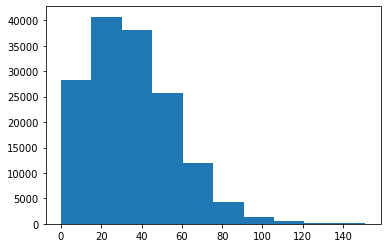

In [23]:
print(streetlights.shape)

plt.hist(streetlights)
plt.show()

In [24]:
# add streetlights feature to crime data
df_crime['streetlights'] = streetlights

In [25]:
df_crime.info()
df_crime.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 151072 entries, 0 to 151071
Data columns (total 45 columns):
crime-type                           151072 non-null object
INCIDENT_NUMBER                      151072 non-null object
OFFENSE_DESCRIPTION                  151072 non-null object
timestamp                            151072 non-null datetime64[ns]
lat                                  151072 non-null float64
lon                                  151072 non-null float64
year                                 151072 non-null object
month                                151072 non-null object
day-of-week                          151072 non-null object
hour                                 151072 non-null object
ZIP5                                 151044 non-null object
ZIP5_area                            151044 non-null object
Name                                 151002 non-null object
Neighborhood_area                    151002 non-null object
Neighborhood_area_2                  15

,crime-type,INCIDENT_NUMBER,OFFENSE_DESCRIPTION,timestamp,lat,lon,year,month,day-of-week,hour,...,tempmin,humavg,windavg,windsustain,windmax,precip,snowfall,time,night,streetlights
0,fraud,I192078177,forgery / counterfeiting,2019-08-01 17:46:00,42.304922,-71.102981,2019,8,Thursday,17,...,23.3,52.0,7.9,14,20,0.00,0.0,1066,0,7
1,harassment-disturbance,I192078061,harassment,2019-06-12 21:00:00,42.355553,-71.152747,2019,6,Wednesday,21,...,15.6,46.0,11.6,20,23,0.00,0.0,1260,0,8
2,theft,I192078038,larceny theft of mv parts & accessories,2019-03-10 08:00:00,42.345625,-71.041291,2019,3,Sunday,8,...,-0.6,83.0,12.8,25,30,0.46,0.9,480,1,26
3,theft,I192078015,larceny all others,2019-07-08 10:29:00,42.339304,-71.051604,2019,7,Monday,10,...,18.9,55.0,7.8,13,15,0.00,0.0,629,0,77
4,theft,I192077997,auto theft - leased/rented vehicle,2019-04-13 08:00:00,42.328564,-71.068353,2019,4,Saturday,8,...,13.9,75.0,14.0,24,32,0.28,0.0,480,1,17


## Create college proximity feature

In [27]:
df_colleges = pd.read_csv(readfile_colleges)

In [28]:
df_colleges.info()
df_colleges.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57 entries, 0 to 56
Data columns (total 29 columns):
Unnamed: 0       57 non-null int64
OBJECTID         57 non-null int64
Match_type       57 non-null object
Ref_ID           57 non-null int64
ID1              42 non-null object
Id               57 non-null int64
SchoolId         57 non-null int64
Name             57 non-null object
Address          57 non-null object
City             57 non-null object
Zipcode          55 non-null float64
Contact          57 non-null object
PhoneNumbe       57 non-null object
YearBuilt        57 non-null int64
NumStories       57 non-null object
Cost             57 non-null int64
NumStudent       57 non-null int64
BackupPowe       57 non-null int64
ShelterCap       57 non-null object
Latitude         57 non-null float64
Longitude        57 non-null float64
Comment          57 non-null object
X                57 non-null float64
Y                57 non-null float64
NumStudent12     38 non-null float64


,Unnamed: 0,OBJECTID,Match_type,Ref_ID,ID1,Id,SchoolId,Name,Address,City,...,Latitude,Longitude,Comment,X,Y,NumStudent12,CampusHous,NumStudents13,URL,Address2013
0,0,1,NCES,0,"Fruit St, Boston, Massachusetts 02114-2696",98627,431594,Massachusetts General Hospital Dietetic Intern...,"Fruit St, Boston, Massachusetts 02114",West End,...,42.362591,-71.070141,0300381001,772340.999867,2.957450e+06,NaN,,20,NaN,NaN
1,1,2,NCES & Consortium,0,"8 Ashburton Place, Boston, Massachusetts 02108...",11959,168005,Suffolk University,"8 Ashburton Pl Beacon Hill, Boston, Massachuse...",Boston,...,42.358905,-71.061948,0302802001,774562.025937,2.956118e+06,9101.0,21%,8675,http://www.suffolk.edu,NaN
2,2,3,NCES & Consortium,0,"41 Berkeley St, Boston, Massachusetts 02116",16632,165884,Benjamin Franklin Institute of Technology,"41 Berkeley St, Boston, Massachusetts 02116",South End,...,42.346103,-71.070186,0500688000,772358.914857,2.951441e+06,472.0,,482,http://www.bfit.edu,NaN
3,3,4,NCES & Consortium,0,"250 New Rutherford Ave, Boston, Massachusetts ...",1949,165112,Bunker Hill Community College,"250 New Rutherford Ave, Boston, Massachusetts ...",Charlestown,...,42.375117,-71.069572,0202170000,772471.759776,2.962015e+06,12934.0,,14023,http://www.bhcc.mass.edu,NaN
4,4,5,NCES & Consortium,0,"36 1st Avenue, Boston, Massachusetts 02129-4557",9109,166869,MGH Institute of Health Professions,"36 1st Avenue, Boston, Massachusetts 02129",Charlestown,...,42.374917,-71.053972,0203504000,776687.321227,2.961964e+06,928.0,,1096,http://www.mghihp.edu,NaN


In [29]:
df_colleges.describe()

,Unnamed: 0,OBJECTID,Ref_ID,Id,SchoolId,Zipcode,YearBuilt,Cost,NumStudent,BackupPowe,Latitude,Longitude,X,Y,NumStudent12,NumStudents13,Address2013
count,57.000000,57.000000,57.0,57.000000,5.700000e+01,55.000000,57.000000,5.700000e+01,57.000000,57.0,57.000000,57.000000,57.000000,5.700000e+01,38.000000,57.000000,0.0
mean,28.000000,29.701754,0.0,42449.473684,4.260381e+05,113572.218182,1756.649123,3.810699e+07,2711.894737,0.0,42.344105,-71.092288,766386.991935,2.950685e+06,5140.105263,2627.456140,NaN
std,16.598193,17.085881,0.0,35280.176536,2.189046e+06,133406.639214,550.555871,9.133320e+07,6184.962668,0.0,0.021252,0.027650,7465.578714,7.754472e+03,8215.530661,5436.010486,NaN
min,0.000000,1.000000,0.0,1949.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.0,42.254000,-71.180351,742669.813147,2.917826e+06,98.000000,0.000000,NaN
25%,14.000000,15.000000,0.0,14097.000000,0.000000e+00,33951.000000,1899.000000,3.189600e+06,0.000000,0.0,42.339187,-71.103478,763367.006004,2.948882e+06,495.750000,0.000000,NaN
50%,28.000000,30.000000,0.0,17534.000000,1.656710e+05,67821.000000,1899.000000,8.714400e+06,594.000000,0.0,42.348500,-71.095494,765546.574808,2.952280e+06,1255.000000,698.000000,NaN
75%,42.000000,44.000000,0.0,86223.000000,1.672240e+05,138158.000000,1945.000000,2.681230e+07,1593.000000,0.0,42.351960,-71.070970,772164.999891,2.953518e+06,4739.000000,2264.000000,NaN
max,56.000000,59.000000,0.0,98627.000000,1.664520e+07,606500.000000,1999.000000,5.227396e+08,31960.000000,0.0,42.381010,-71.039202,780798.454737,2.964159e+06,32439.000000,32411.000000,NaN


In [72]:
%%time

# set distance in meters to identify crime proximal to colleges 
threshold = 500

# convert locations to numpy array for calculating distances
college_locs = df_colleges[['Latitude', 'Longitude']].values

# generate array of calculated distances for all crimes to all colleges
college_distances = distance(crime_locs[:, None], college_locs)

# identify minimum distances and associated college populations for each crime
min_idx = np.argmin(college_distances, axis=1)
min_distances = np.min(college_distances, axis=1)
min_populations = df_colleges['NumStudent'].values[min_idx]

# create proximity indicator based on threshold distance
near_college = (min_distances<threshold).astype(int)

CPU times: user 156 ms, sys: 44 ms, total: 200 ms
Wall time: 199 ms


In [75]:
print(
    'The number of crimes within {} meters of a college or university is:  {:,}'\
    ''.format(threshold, np.sum(near_college))
)

The number of crimes within 500 meters of a college or university is:  43,830


In [76]:
df_crime['college_distance'] = min_distances
df_crime['college_near'] = near_college

In [77]:
df_crime.info()
df_crime.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 151072 entries, 0 to 151071
Data columns (total 47 columns):
crime-type                           151072 non-null object
INCIDENT_NUMBER                      151072 non-null object
OFFENSE_DESCRIPTION                  151072 non-null object
timestamp                            151072 non-null datetime64[ns]
lat                                  151072 non-null float64
lon                                  151072 non-null float64
year                                 151072 non-null object
month                                151072 non-null object
day-of-week                          151072 non-null object
hour                                 151072 non-null object
ZIP5                                 151044 non-null object
ZIP5_area                            151044 non-null object
Name                                 151002 non-null object
Neighborhood_area                    151002 non-null object
Neighborhood_area_2                  15

,crime-type,INCIDENT_NUMBER,OFFENSE_DESCRIPTION,timestamp,lat,lon,year,month,day-of-week,hour,...,windavg,windsustain,windmax,precip,snowfall,time,night,streetlights,college_distance,college_near
0,fraud,I192078177,forgery / counterfeiting,2019-08-01 17:46:00,42.304922,-71.102981,2019,8,Thursday,17,...,7.9,14,20,0.00,0.0,1066,0,7,2719.884235,0
1,harassment-disturbance,I192078061,harassment,2019-06-12 21:00:00,42.355553,-71.152747,2019,6,Wednesday,21,...,11.6,20,23,0.00,0.0,1260,0,8,1315.155113,0
2,theft,I192078038,larceny theft of mv parts & accessories,2019-03-10 08:00:00,42.345625,-71.041291,2019,3,Sunday,8,...,12.8,25,30,0.46,0.9,480,1,26,1543.501741,0
3,theft,I192078015,larceny all others,2019-07-08 10:29:00,42.339304,-71.051604,2019,7,Monday,10,...,7.8,13,15,0.00,0.0,629,0,77,1422.033321,0
4,theft,I192077997,auto theft - leased/rented vehicle,2019-04-13 08:00:00,42.328564,-71.068353,2019,4,Saturday,8,...,14.0,24,32,0.28,0.0,480,1,17,797.819824,0


(array([5.1676e+04, 2.6285e+04, 2.6681e+04, 2.7243e+04, 1.3784e+04,
        3.1100e+03, 2.0260e+03, 2.3600e+02, 2.9000e+01, 2.0000e+00]),
 array([  15.26190048,  636.89201435, 1258.52212821, 1880.15224207,
        2501.78235593, 3123.41246979, 3745.04258365, 4366.67269751,
        4988.30281137, 5609.93292523, 6231.5630391 ]),
 <a list of 10 Patch objects>)

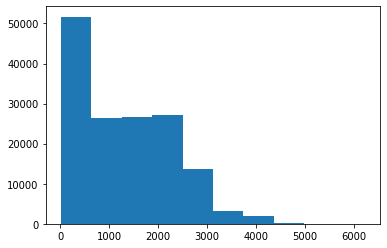

In [49]:
plt.hist(min_distances)

In [62]:
df_colleges.loc[df_colleges['NumStudent']==0]

,Unnamed: 0,OBJECTID,Match_type,Ref_ID,ID1,Id,SchoolId,Name,Address,City,...,Latitude,Longitude,Comment,X,Y,NumStudent12,CampusHous,NumStudents13,URL,Address2013
13,13,14,Consortium,0,NaN,15399,0,Boston University Research,771 Commonwealth Ave,Fenway/Kenmore,...,42.350833,-71.109001,2100360000,761858.236712,2.953115e+06,NaN,NaN,0,NaN,NaN
14,14,15,Consortium,0,NaN,15400,0,Boston University School of Law,1 University Rd,Fenway/Kenmore,...,42.351162,-71.109773,2100392000,761649.084571,2.953234e+06,NaN,NaN,0,http://www.bu.edu/law/about/overview.html,NaN
15,15,16,Consortium,0,NaN,15282,0,Boston University Sargent College,635 Commonwealth Ave,Fenway/Kenmore,...,42.349835,-71.102045,0504089000,763740.173893,2.952760e+06,NaN,NaN,0,http://www.bu.edu/sargent/about-us/fast-facts/,NaN
16,16,17,Consortium,0,NaN,16275,0,Boston University School of Management,595 Commonwealth Ave,Fenway/Kenmore,...,42.349438,-71.098109,0503981000,764804.999847,2.952620e+06,NaN,NaN,0,NaN,NaN
17,17,18,Consortium,0,NaN,16291,0,Boston University Admissions,121 Bay State Rd,Fenway/Kenmore,...,42.350434,-71.098849,0504037000,764603.157731,2.952982e+06,NaN,NaN,0,NaN,NaN
18,18,19,Consortium,0,NaN,16267,0,Boston University Rental Office,19 Deerfield Rd,Fenway/Kenmore,...,42.349540,-71.097010,0503757000,765101.799450,2.952659e+06,NaN,NaN,0,NaN,NaN
19,19,20,Consortium,0,NaN,84599,0,Boston University Trustees,25 Buick Street,Allston/Brighton,...,42.351960,-71.115230,2100400000,760172.676107,2.953518e+06,NaN,NaN,0,NaN,NaN
20,20,22,Consortium,0,NaN,17534,0,Boston University School of Medicine,85 East Newton St,South End,...,42.336388,-71.070970,0801408000,772164.999891,2.947900e+06,NaN,NaN,0,NaN,NaN
21,21,23,Consortium,0,NaN,17638,0,Boston University Public Health,715 Albany St,South End,...,42.335319,-71.071624,0801418000,771990.054375,2.947510e+06,NaN,NaN,0,http://www.bu.edu/sph/about/busph-at-a-glance/,NaN
23,23,25,Consortium,0,"300 The Fenway, Boston, Massachusetts 02115-5898",86676,0,Simmons College,94 Pilgrim Rd.,Fenway/Kenmore,...,42.341050,-71.105896,0402012000,762714.170367,2.949554e+06,NaN,,4655,NaN,NaN


In [61]:
df_colleges['NumStudent'].value_counts()

0        16
147       1
144       1
4252      1
31960     1
23        1
2454      1
249       1
467       1
594       1
27537     1
4145      1
1406      1
205       1
4556      1
5003      1
10        1
1096      1
900       1
11009     1
669       1
158       1
1055      1
3808      1
2749      1
9148      1
448       1
1593      1
119       1
2422      1
765       1
15036     1
754       1
753       1
145       1
619       1
682       1
617       1
785       1
484       1
700       1
14912     1
Name: NumStudent, dtype: int64